In [1]:
import matplotlib.pyplot as plt
import numpy as np
from QuestionProcessor import QuestionProcessor

question_processor = QuestionProcessor("./export.json")  

General Questions: 6
General Answers: 210


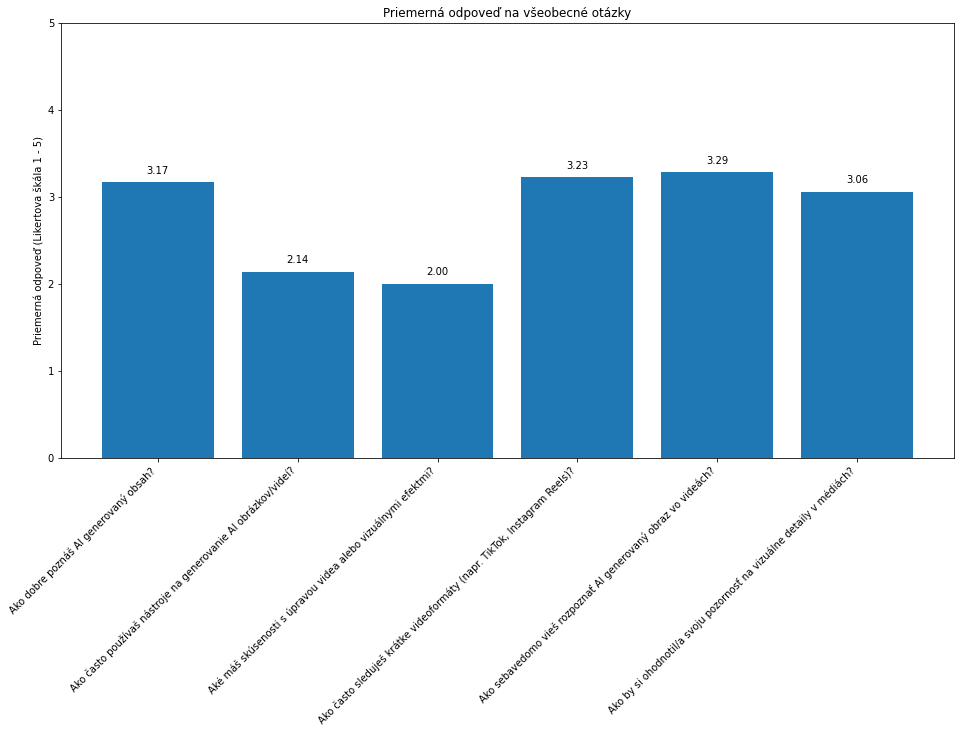

In [ ]:
# Evaluate the general questions and answers

general_questions_and_answers = question_processor.get_general_questions_and_answers()
question_texts = []
question_averages = []

for qa in general_questions_and_answers:
    question = qa[0]
    answers = qa[1]

    values = [a['answer'] for a in answers]
    if values:
        average = sum(values) / len(values)
        question_averages.append(average)
        question_texts.append(question['titleSk'])
        
        
plt.figure(figsize=(16, 8))
bars = plt.bar(question_texts, question_averages)
plt.title("Priemerná odpoveď na všeobecné otázky")
plt.ylabel("Priemerná odpoveď (Likertova škála 1 - 5)")
plt.ylim(0, 5)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f"{yval:.2f}", ha='center')

plt.show()